In [2]:
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import pandas as pd

import scrublet as scr

from sklearn.neighbors import NearestNeighbors

import pickle

In [3]:
raw_obj = "../data/CART_raw_data.h5ad"
ip_obj = "../data/IP_specific_clustering.h5ad"
pbmc_annot = "../data/PBMC_specific_clustering_obs.csv"


In [2]:
adata = read_h5ad_gs(raw_obj)

## Subset to T-cells

In [ ]:
obs = pd.read_csv(pbmc_annot)
obs = obs[obs['cell_type']=='T']

adata = adata[obs.index]
adata.obs = obs

## Compute T-cell-specific PCA

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=3, min_disp=0.2)

# Blacklist genes
adata.var.loc[['XIST','RPS4Y1','RPS4Y2','Yescarta','Kymriah','HBB','HBA1','HBA2'],'highly_variable'] = False
adata.var.loc[adata.var.index.str.match('TR.V|IG.V'),'highly_variable'] = False

adata.raw = adata

adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

## Compute nearest neighbors

In [4]:
k=100
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(adata.obsm['X_pca'])

In [5]:
distances, indices = nbrs.kneighbors(adata.obsm['X_pca'])

In [5]:
markers = ['CD4','CD8A','CD3D']

for gene in markers:
    adata.obs['knn'+gene] = adata.raw[:,gene].X[indices.reshape(-1)].reshape(-1,100).mean(axis=1)

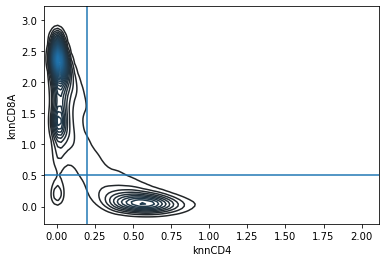

In [10]:
sns.kdeplot(adata.obs['knnCD4'],adata.obs['knnCD8A'],levels=30)
plt.axvline(.2)
plt.axhline(.5)

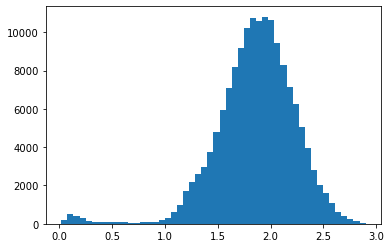

In [13]:
plt.hist(adata.obs['knnCD3D'],50);

In [20]:
# Do the cell sorting

cd4_thresh = .2
cd8_thresh=.5
cd3_thresh=.75

adata.obs['subtype'] = 'Unknown'
idx = (adata.obs['knnCD4']>cd4_thresh)&(adata.obs['knnCD8A']<cd8_thresh)&(adata.obs['knnCD3D']>cd3_thresh)
adata.obs.loc[idx,'subtype']='CD4 T'

idx = (adata.obs['knnCD4']<cd4_thresh)&(adata.obs['knnCD8A']>cd8_thresh)&(adata.obs['knnCD3D']>cd3_thresh)
adata.obs.loc[idx,'subtype']='CD8 T'


In [21]:
pbmc_classifications = adata.obs.loc[adata.obs['subtype']!="Unknown",'subtype']
pbmc_classifications.to_csv('T_PBMC_CD_classifications.txt',sep='\t')

## Repeat for IP

In [24]:
adata_ip = read_h5ad_gs(ip_obj)

In [25]:
markers = ['CD4','CD8A','CD3D']


In [26]:
def smooth_markers(adata,markers):
    nbrs = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(adata.obsm['X_pca'])
    distances, indices = nbrs.kneighbors(adata.obsm['X_pca'])

    for gene in markers:
        adata.obs['knn'+gene] = adata.raw[:,gene].X[indices.reshape(-1)].reshape(-1,100).mean(axis=1)
    return adata,nbrs,distances,indices

In [30]:
adata_ip,nbrs,distances,indices = smooth_markers(adata_ip,markers)

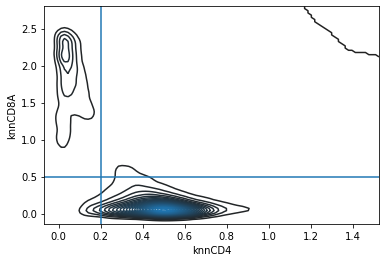

In [32]:
sns.kdeplot(adata_ip.obs['knnCD4'],adata_ip.obs['knnCD8A'],levels=30)
plt.axvline(.2)
plt.axhline(.5)

In [33]:
cd4_thresh = .2
cd8_thresh=.5
cd3_thresh=.75

adata_ip.obs['subtype'] = 'Unknown'
idx = (adata_ip.obs['knnCD4']>cd4_thresh)&(adata_ip.obs['knnCD8A']<cd8_thresh)&(adata_ip.obs['knnCD3D']>cd3_thresh)
adata_ip.obs.loc[idx,'subtype']='CD4 T'

idx = (adata_ip.obs['knnCD4']<cd4_thresh)&(adata_ip.obs['knnCD8A']>cd8_thresh)&(adata_ip.obs['knnCD3D']>cd3_thresh)
adata_ip.obs.loc[idx,'subtype']='CD8 T'


In [37]:
ip_classifications = adata_ip.obs.loc[adata_ip.obs['subtype']!="Unknown",'subtype']

ip_classifications.to_csv('Tinfusion_CD_classifications.txt',sep='\t')

In [ ]:
all_classifications = pd.concat([pbmc_classifications,ip_classifications],axis=0)

all_classifications.to_csv('../data/ALLT_CD_classifications.txt',sep='\t')